![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [27]:
rental = pd.read_csv('rental_info.csv')
rental.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [28]:
rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [29]:
rental.describe()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


In [30]:
rental['release_year'] = rental['release_year'].astype('int')
rental['rental_date'] = pd.to_datetime(rental['rental_date'])
rental['return_date'] = pd.to_datetime(rental['return_date'])

In [31]:
rental['rental_length_days'] = (rental['return_date'] - rental['rental_date']).dt.days
rental.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4


In [32]:
rental['special_features'].value_counts()

{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers}                                                      1139
{Trailers,Commentaries}                                         1129
{Trailers,"Behind the Scenes"}                                  1122
{"Behind the Scenes"}                                           1108
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries}                                                  1089
{Commentaries,"Behind the Scenes"}                              1078
{Trailers,"Deleted Scenes"}                                     1047
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Deleted Scenes"}                                 1011
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,"Deleted Scenes","Behind

In [33]:
rental['deleted_scenes'] = np.where(rental['special_features'].str.contains('Deleted Scenes'), 1, 0)
rental['behind_the_scenes'] = np.where(rental['special_features'].str.contains('Behind the Scenes'), 1, 0)

In [34]:
X = rental.drop(['special_features', 'rental_date', 'return_date', 'rental_length_days'], axis=1)
y = rental['rental_length_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

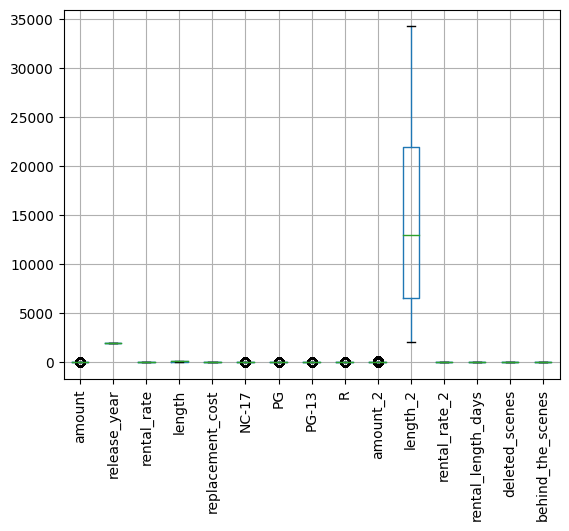

In [35]:
rental.boxplot()
plt.xticks(rotation=90)
plt.show()

In [36]:
lasso = Lasso(alpha=0.3, random_state=9)

lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

lin_reg = LinearRegression()
lin_reg.fit(X_lasso_train, y_train)

lin_reg_lasso_pred = lin_reg.predict(X_lasso_test)
mse_lin_reg_lasso = mean_squared_error(y_test, lin_reg_lasso_pred)
print('mean squared error for linear regression with lasso: ', mse_lin_reg_lasso)

mean squared error for linear regression with lasso:  4.812297241276244


In [37]:
rf = RandomForestRegressor()
params = {'n_estimators': np.arange(1, 101, 1),
          'max_depth': np.arange(1, 11, 1)}

rscv = RandomizedSearchCV(rf, param_distributions=params, cv=5, random_state=9)
rscv.fit(X_train, y_train)

hyper_params = rscv.best_params_
print('best hyperparameters: ', hyper_params)

best hyperparameters:  {'n_estimators': 51, 'max_depth': 10}


In [38]:
rf = RandomForestRegressor(n_estimators=hyper_params['n_estimators'], 
                           max_depth=hyper_params['max_depth'], 
                           random_state=9)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, rf_pred)
print('mean squared error for random forest: ', mse_rf)

mean squared error for random forest:  2.225667528098759


In [39]:
best_model = rf
best_mse = mse_rf